# Smash GAN

Generating new Super Smash Bros. Ultimate characters using GANs.

## Imports

In [67]:
%matplotlib inline

import logging
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils

from datetime import datetime
from IPython.display import HTML
from PIL import Image

## Reproducibility

In [68]:
# Set random seed for reproducibility
seed = 999
random.seed(seed)
torch.manual_seed(seed);

## Algorithm

We'll use the [DCGAN](https://arxiv.org/abs/1511.06434) model. It has had great success in the past for image synthesis tasks. The caveat is that it works best with **64 x 64** images. In this case, this doesn't take advantage of the fact that we have high resolution images which we'll have to resize.

## Inputs

In [69]:
dataroot = "data"
workers = 2
batch_size = 128
image_size = 64

# Number of channels in the training images
nc = 3

# Size of z latent vector (i.e. size of generator input) based on the DCGAN paper
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# TODO: Tune the number of epochs
num_epochs = 100

# TODO: Tune this probability
# Probability of random augmentation
aug_prob = 0.25

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available (0 will be CPU only)
ngpu = 1

## Data

We'll use the official Nintendo [images](https://www.smashbros.com/en_US/fighter/index.html) of 78 characters of the game. We excluded `Mii Fighter` because the images have the labels of each type, and we didn't want the generative model to get confused by that. In total, we have **624 images** (78 characters with 8 different skins each one). The script `download_characters.py` takes care of downloading all images and placing them in the `data/` directory, in a format that can be used with the data loader.

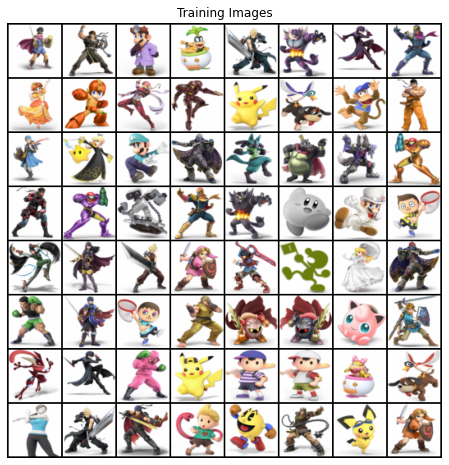

In [70]:
# Define a custom loader that colors the transparent background of the images
# If we don't do this the transparency causes issues when resizing the images
# See: https://stackoverflow.com/a/35859141
def loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        img.convert("RGBA")

        # Create a white image
        new_img = Image.new('RGBA', img.size, (255, 255, 255, 255))
        # Paste the original image into this new white background using the alpha channel as mask
        new_img.paste(img, mask=img.split()[-1])

        # Now return the image as RGB
        return new_img.convert('RGB')

# Create the dataset
dataset = dset.ImageFolder(
    root=dataroot,
    loader=loader,
    # Preprocess the images to match what DCGAN expects
    transform=transforms.Compose([
        transforms.Resize((image_size, image_size)),
        # Apply some data augmentation since we don't have a large training set
        transforms.RandomHorizontalFlip(),
        # This converts the image to a PyTorch tensor with dimensions channels x height x width
        # and it also rescales the pixel values from [0, 255] to [0, 1]
        transforms.ToTensor(),
        # We use a mean and std dev of 0.5 to normalize the values from [0, 1] to [-1, 1] as specified by the paper
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

## Model Implementation

### Weight Initialization

From the DCGAN paper, the authors specify that all model weights sould be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. However, what they don't specify is that this initialization should only be done for the **convolutional** layers. The Batch Norm layers should use a different mean; specifically, $\mu=1$. This is taken from their original implementation [here](https://github.com/soumith/dcgan.torch/blob/master/main.lua#L42).

In [71]:
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

The generator, $G$, is designed to map the latent space vector ($z$) to the space of the data. In our case, this means converting it into an RGB image with the same size as the training images (i.e. 3x64x64). This is accomplished through a series of strided 2D **convolutional transpose** (i.e. fractionally-strided convolution) layers. Note that this upsampling could be done using **pooling layers**; however, the DCGAN paper specifies that all pooling should be eliminated. Furthermore, the authors also suggest adding **Batch Norm** and using **ReLU** for all activations. Finally, the output of the generator is fed through a **tanh** function to return it to the range of the input data, $[-1,1]$.

In [72]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()

        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=ngf * 8),
            nn.ReLU(inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [73]:
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

### Discriminator

The discriminator, $D$, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake), $D(x)$. As mentioned in the DCGAN paper, $D$ uses **normal strided convolutions** (as with the generator these are used for controlling the volume as opposed to using pooling layers), **Batch Norm**, and **LeakyReLU** for all the activations. The output is passed through a **sigmoid** function to obtain the probability between $[0,1]$.

In [74]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()

        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
            # Use 0.2 for the slope as recommended by the DCGAN paper
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)

In [75]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

### Loss Functions and Optimizers

The generator $G$ maximizes $\log(D(G(z)))$, while the discriminator $D$ maximizes $\log(D(x)) + \log(1 - D(G(z)))$. We can use the **Binary Cross-entropy Loss** which is defined as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

This function provides the calculation of both components. For the discriminator, the equation can be used as-is. For the generator, we need to make sure that we only use the $log(D(x))$ part (where $x = G(z)$). This can be accomplished by setting the $y$ labels as 1, which eliminate the second component due to $1 - y_n$. This will be done by the training loop.

Next, we define our real label as 1 and the fake label as 0. These labels will be used when calculating the losses of $D$ and
$G$, and this is also the convention used in the original GAN paper.

Finally, we set up two separate optimizers, one for $D$ and one for $G$. As specified in the DCGAN paper, both are `Adam` optimizers with $\alpha=0.0002$ and $\beta_1$ = 0.5. $\beta_2$ will use the deault value of 0.999.

Note that we will also create a batch of 64 random samples, from a Gaussian distribution, of size `nz`. These will be used as _fixed noise_ that we'll pass through our generator to track its progress.

In [76]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

Training will be done following the original algorithm devised by Goodfellow. However, we'll modify some of its components to improve the convergence. These best practices are outlined in [ganhacks](https://github.com/soumith/ganhacks). Concretely, we will train the discriminator with separate batches of **real** and **fake** images (as opposed to combining them into a single batch as originally outlined by Goodfellow).

Training is split into two parts. First we train the discriminator. Then, we trained the generator.

### Part 1 - Discriminator

The discriminator maximizes $\log(D(x)) + \log(1-D(G(z)))$. Due to the separate mini-batch suggestion, we will calculate this in two steps.

First:

1. Construct a batch of **real** samples from the training set
2. Forward pass through $D$
3. Calculate the loss ($\log(D(x))$; using $y=1$)
4. Calculate the gradients in a backward pass

Second:

1. Construct a batch of **fake** samples with the _current_ generator
2. Forward pass this batch through $D$
3. Calculate the loss ($log(1-D(G(z)))$; using $y=0$)
4. *Accumulate* the gradients with a backward pass

Now, with the gradients accumulated from both the all-real and all-fake batches, we can optimize it.

#### Dealing With Low Data

Because we only have a little over 600 images; training might not actually converge to a satisfiable solution. Recently, researches have devised a way of dealing this problem. They proposed an approach for doing stochastic augmentation of the images, **both fake and real**, going in into the discriminator. The key idea is that if the augmentation is done with a relatively low probability; these augmentation won't _leak_ into the generator. In other words, the generator won't start learning to produce the transformed images, which might be undesirable for certain applications.

Based on their research, they determined that affine transformations can be used to produce the augmentations. In our case, we will use a **horizontal flip**, to be consistent with the random flip that we are already doing as part of the data loader transformation pipeline. Finally, it's recommended to use a probability of augmentation of no more than 70%.

### Part 2 - Generator

The generator maximizes $\log(D(G(z)))$. We do this by:

1. Classifying the same **fake** samples from Part 1 with the now _updated_ discriminator
2. Computing $G$’s loss using the _real_ labels ($y=1$), so we can focus on the second component of the cross-entropy loss ($\log(D(x)$)
3. Computing $G$’s gradients in a backward pass
4. Updating $G$’s parameters with an optimizer step.

As part of the training, we will also report the following metrics:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches.
-  **Loss_G** - generator loss calculated
-  **D(x)** - the average output (across the batch) of the discriminator for the all real batch.
   This should start close to 1 then theoretically converge to 0.5 when $G$ gets better (i.e. confusing the discriminator more).
-  **D(G(z))** - the average output (across the batch) of the discriminator for the all fake batch.
   The first number is before $D$ is updated and the second number is after $D$ is updated.
   These numbers should start near 0 and converge to 0.5 as $G$ gets better.

Finally at the end of each epoch we will push our _fixed noise_ batch through the generator to visually track the progress of $G$’s training.

In [77]:
# Part 1 - Discriminator
def augment(images):
    return TF.hflip(images) if random.random() < aug_prob else images

def train_discriminator(real, fake, b_size):
    netD.zero_grad()
    
    # Apply augmentation
    real = augment(real)
    fake = augment(fake)

    # Train with all-real batch
    # Use y = 1 (real label)
    label = torch.full((b_size,), real_label, device=device)
    # Forward pass
    output = netD(real).view(-1)
    # Calculate loss
    loss_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    loss_real.backward()
    # Track mean output for the batch
    D_x = output.mean().item()
    
    # Train with all-fake batch
    # Use y = 0 (fake label)
    label = torch.full((b_size,), fake_label, device=device)
    # Classify all fake batch
    # We need to use `detach` to tell PyTorch we don't want to track the computations done on `fake`
    # This is needed because `fake` is used twice: once here by the discriminator and another time
    # by the generator. If we don't add `detach` then when training the generator, PyTorch complains
    # that the computations of `fake` were tracked and "freed" previously. This is because when calling
    # `backward` the graph is cleared and therefore `fake` won't be available anymore to use by the
    # generator. See this comment: https://github.com/pytorch/examples/issues/116#issuecomment-401579280
    output = netD(fake.detach()).view(-1)
    # Calculate D's loss
    loss_fake = criterion(output, label)
    # Calculate the gradients
    loss_fake.backward()
    # Track mean output _before_ updating D
    D_G_z1 = output.mean().item()

    # Add the gradients from the all-real and all-fake batches
    errD = loss_real + loss_fake
    # Update D
    optimizerD.step()
    
    return errD, D_x, D_G_z1

In [78]:
# Part 2 - Generator
def train_generator(fake, b_size):
    netG.zero_grad()

    # Use y = 1 (real label)
    label = torch.full((b_size,), real_label, device=device)
    # Classify all-fake batch through now updated D
    output = netD(fake).view(-1)
    # Calculate loss
    errG = criterion(output, label)
    # Calculate gradients
    errG.backward()
    # Track mean output with _updated_ D
    D_G_z2 = output.mean().item()

    # Update G
    optimizerG.step()

    return errG, D_G_z2

In [79]:
# For keeping track of progress
img_list = []  # The images produced by our generator using the fixed noise
G_losses = []  # All G's losses
D_losses = []  # All D's losses
iters = 0
start = time.time()

# Define a log file where to write
logging.basicConfig(filename=f'run_{datetime.utcnow():%Y-%m-%d-%H-%M-%S}.log', level=logging.INFO, filemode='w')
logging.info('Starting Training')

for epoch in range(num_epochs):
    # Loop through the batches
    for i, data in enumerate(dataloader, 0):
        # Get the batch of real samples
        real = data[0].to(device)
        # Get the batch size in case it isn't the full `batch_size` we specified in our inputs
        b_size = real.size(0)

        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with the current G
        fake = netG(noise)

        # Part 1- Discriminator
        errD, D_x, D_G_z1 = train_discriminator(real, fake, b_size)
        # Part 2 - Generator
        errG, D_G_z2 = train_generator(fake, b_size)

        # Output training stats
        logging.info('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                     % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            # We use `no_grad` so that PyTorch doesn't keep track of computations here since we're not going to
            # compute any gradients from this forward pass
            with torch.no_grad():
                # We detach (i.e. don't save the computations since we don't need gradients)
                # and move the generated images to CPU so that we can save them locally
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

end = time.time()
logging.info(f'Training Done. Elapsed: {end -start} seconds')

## Results

### Loss versus training iteration

Below is a plot of $D$ and $G$’s losses versus training iterations.

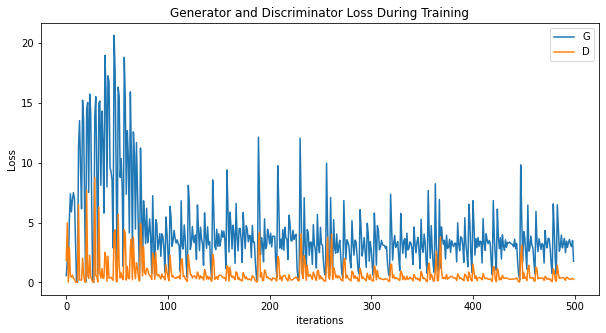

In [80]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show();

### Visualization of $G$’s progression

We can visualize the training progression of $G$ with an animation from the outputs we saved using our fixed noise.

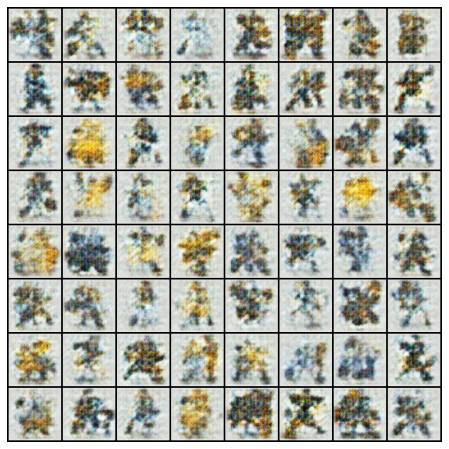

In [81]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Real Images vs. Fake Images

Let's look at some real vs fake characters side to side!

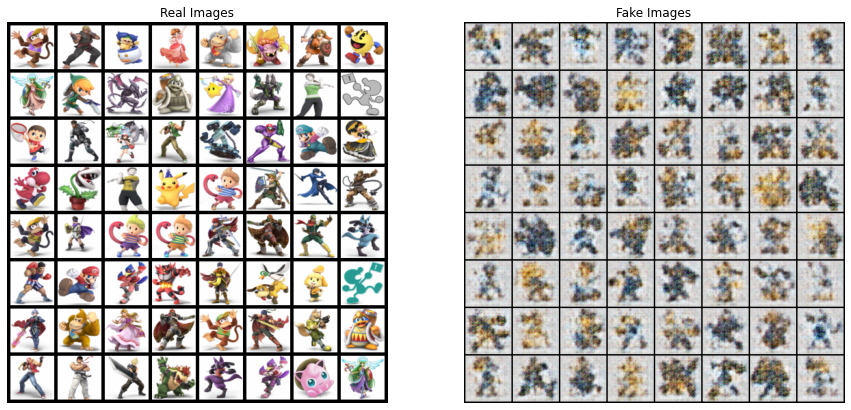

In [66]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

> TODO: Save the generator whenever we achieve good performance!

## Resources

- [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434)
- [Image Augmentations for GAN Training](https://arxiv.org/abs/2006.02595)
- [Training Generative Adversarial Networks with Limited Data](https://arxiv.org/abs/2006.06676)
- [DCGAN PyTorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)